In [37]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Input,InputLayer, Activation, BatchNormalization
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
import numpy as np
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
from keras.callbacks import EarlyStopping

In [38]:
labels = ['NORMAL', 'PNEUMONIA']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img = cv2.imread(img_path)
                if img is None:
                    continue  # Skip if the image cannot be loaded

                resized_arr = cv2.resize(img, (img_size, img_size))
                
                contrast = int((177 - 0) * (127 - (-127)) / (254 - 0) + (-127))
                Alpha = float(131 * (contrast + 127)) / (127 * (131 - contrast))
                Gamma = 127 * (1 - Alpha)
                cntrst = cv2.addWeighted(resized_arr, Alpha, resized_arr, 0, Gamma)
                
                data.append([cntrst, class_num])
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
    return np.array(data, dtype=object)


In [39]:
train = get_data(r"D:\purpose.D drive\pneumoniaxray\xray_chest\train")

x_train = []
y_train = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

In [40]:
test = get_data(r"D:\purpose.D drive\pneumoniaxray\xray_chest\test")
val = get_data(r"D:\purpose.D drive\pneumoniaxray\xray_chest\val")

In [41]:
x_val=[]
y_val=[]
x_test = []
y_test = []

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

In [42]:
# Normalize the data
x_train = np.array(x_train,dtype=np.float16) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

In [43]:
x_test = np.array(x_test,dtype=np.float16) / 255
x_val = np.array(x_val,dtype=np.float16) / 255

In [44]:
x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [45]:
# training data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
datagen.fit(x_train)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the base ResNet50 model
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
output = restnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
restnet = Model(restnet.input, outputs=output)

# Make all layers trainable
for layer in restnet.layers:
    layer.trainable = True

restnet.summary()

In [ ]:
# Define the custom head
x = Flatten()(restnet.output)
x = Dense(2048, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activity_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.5)(x)
x = Dense(2048, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3), activity_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2), activity_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create a new model
resnet50_model = Model(inputs=restnet.input, outputs=predictions)

resnet50_model.summary()

In [48]:
# Optimizer and learning rate scheduling
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=1e-6)

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [49]:
# Compile the model
resnet50_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])


In [50]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [51]:
# Fit the model
history = resnet50_model.fit(
    datagen.flow(x_train, y_train, batch_size=16),  # Use augmented data
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=[es, lr_reduction]
)

Epoch 1/10


d:\purpose.D drive\pneumoniaxray\envxray\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


326/326 ━━━━━━━━━━━━━━━━━━━━ 1805s 5s/step - accuracy: 0.8415 - loss: 117.6192 - val_accuracy: 0.6250 - val_loss: 39.3100 - learning_rate: 1.0000e-04
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 1791s 5s/step - accuracy: 0.9496 - loss: 27.0414 - val_accuracy: 0.6250 - val_loss: 9.9621 - learning_rate: 1.0000e-04
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 1799s 6s/step - accuracy: 0.9624 - loss: 6.3481 - val_accuracy: 0.6538 - val_loss: 3.8797 - learning_rate: 1.0000e-04
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 1787s 5s/step - accuracy: 0.9680 - loss: 2.5337 - val_accuracy: 0.9151 - val_loss: 1.8597 - learning_rate: 1.0000e-04
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 1760s 5s/step - accuracy: 0.9643 - loss: 1.5900 - val_accuracy: 0.9279 - val_loss: 1.3252 - learning_rate: 1.0000e-04
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 1755s 5s/step - accuracy: 0.9720 - loss: 1.1470 - val_accuracy: 0.9022 - val_loss: 1.1238 - learning_rate: 1.0000e-04
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 1757s 5s/step - acc

In [52]:
# Save the entire model to a file
model_path = r'D:\purpose.D drive\pneumoniaxray\xray_chest\restnet50finalsaved.h5'
resnet50_model.save(model_path)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


<Figure size 800x600 with 0 Axes>

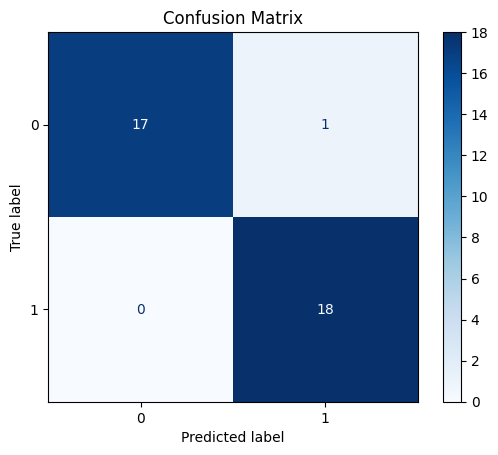

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

# Load the saved VGG19 model
resnet50_model = tf.keras.models.load_model(r'D:\purpose.D drive\pneumoniaxray\xray_chest\restnet50finalsaved.h5')

# Assuming you have your validation data (x_val and y_val)
# Make predictions for the validation set
y_pred = resnet50_model.predict(x_val)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary classes (0 or 1)

# Ensure y_val is in binary labels format (0 or 1)
y_val_classes = y_val.flatten()  # Flatten if necessary, assuming y_val is already shaped appropriately

# Calculate confusion matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Adjust display_labels based on your classes
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [60]:
from sklearn.metrics import classification_report, accuracy_score

# Load the saved VGG19 model
resnet50_model = tf.keras.models.load_model(r'D:\purpose.D drive\pneumoniaxray\xray_chest\restnet50finalsaved.h5')

# Assuming you have your test data (x_test and y_test)
# Make predictions for the test set
predictions = resnet50_model.predict(x_test)

# Convert the predicted probabilities to class labels for binary classification
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Ensure y_test is in binary labels format (0 or 1)
y_test_classes = y_test.flatten()  # Flatten if necessary, assuming y_test is already shaped appropriately

# Print the classification report
print(classification_report(y_test_classes, predicted_classes, target_names=['NORMAL (Class 0)', 'PNEUMONIA (Class 1)']))

# Calculate and print the accuracy
accuracy = accuracy_score(y_test_classes, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print the precision and recall
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test_classes, predicted_classes, zero_division=1)
recall = recall_score(y_test_classes, predicted_classes, zero_division=1)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
                     precision    recall  f1-score   support

   NORMAL (Class 0)       0.98      0.82      0.90       234
PNEUMONIA (Class 1)       0.90      0.99      0.94       390

           accuracy                           0.93       624
          macro avg       0.94      0.91      0.92       624
       weighted avg       0.93      0.93      0.93       624

Accuracy: 0.9279
Precision: 0.9040
Recall: 0.9897


In [1]:
from tensorflow.keras.models import load_model

# Load your saved model
model = load_model(r'D:\purpose.D drive\pneumoniaxray\xray_chest\restnet50finalsaved.h5')

# Evaluate on a validation set
validation_loss, validation_accuracy = model.evaluate(x_val, y_val)
print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy}')


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'D:\purpose.D drive\pneumoniaxray\xray_chest\restnet50finalsaved.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [62]:
# Prediction function with threshold adjustment
def predict_with_threshold(model, image_path, threshold=0.5):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)[0][0]
    label = 'Pneumonia' if prediction >= threshold else 'Normal'
    
    plt.imshow(img)
    plt.title(f'Predicted: {label} ({prediction:.2f})')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


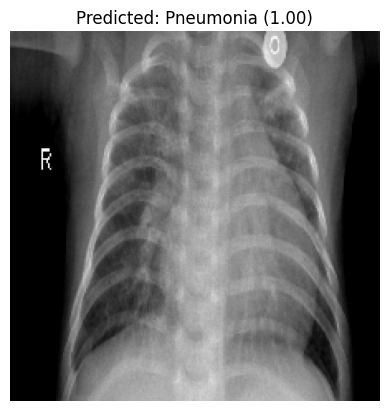

In [63]:
# Example usage
predict_with_threshold(resnet50_model, (r'D:\purpose.D drive\pneumoniaxray\person41_bacteria_211.jpeg'), threshold=0.7)